In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import matplotlib.colors as cls
import cv2 as cv

In [2]:
fp = ''
fnames = ['teflon.bmp', 'teflonEdge.bmp', 'teflonEpoxy.bmp', 'teflonSpecs.bmp']

In [3]:
im0 = np.array(Image.open(fp + fnames[0]))
imf = np.array(ImageOps.flip(Image.open(fp + fnames[0])))
imr = np.array((Image.open(fp + fnames[0])).rotate(180))
im1 = np.array(Image.open(fp + fnames[1]))
im2 = np.array(Image.open(fp + fnames[2]))
im3 = np.array(Image.open(fp + fnames[3]))
imArr = [im0, imf, imr, im1, im2, im3]
imTitle = ['im0Clean', 'im0Flip', 'im0Rotate', 'im1Edge', 'im2Epoxy', 'im3SpecsEdge']

### Convert RGB to Grayscale

In [4]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

### Images in RGB

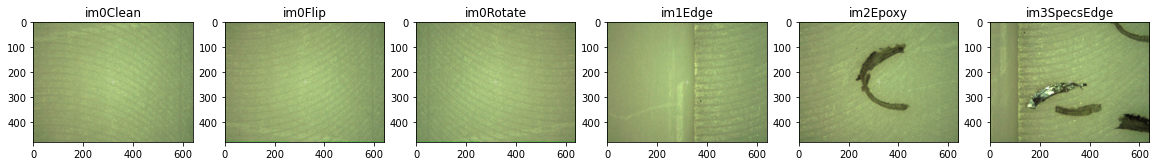

In [5]:
fig= plt.figure(figsize=(20,3))
axs = fig.subplots(1, 6)
for i in range(len(imArr)):
    axs[i].imshow(imArr[i], vmin = 0, vmax = 1)
    axs[i].set_title(imTitle[i])
plt.show(); plt.close()

### Images in Grayscale

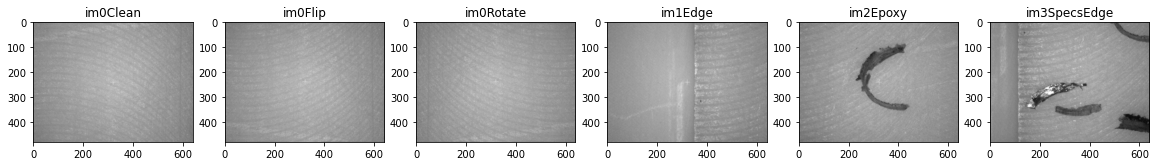

In [6]:
fig= plt.figure(figsize=(20,3))
axs = fig.subplots(1, 6)
# norm = cls.Normalize(vmin=0, vmax=1)
# sm = plt.cm.ScalarMappable(cmap='gray', norm=norm)
# plt.colorbar(sm, ax = axs[-1])

for i in range(len(imArr)):
    axs[i].imshow(rgb2gray(imArr[i])/255, cmap='gray', vmin = 0, vmax = 1) 
    axs[i].set_title(imTitle[i])

plt.show(); plt.close()

### Difference w.r.t baseline

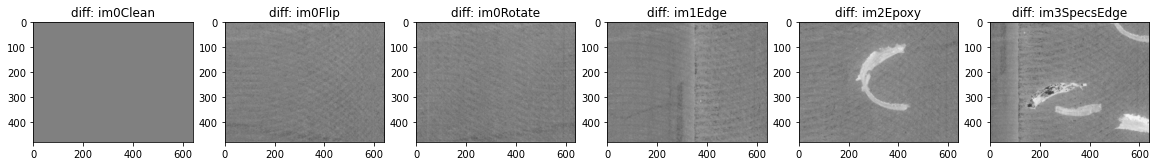

In [7]:
fig= plt.figure(figsize=(20,3))
axs = fig.subplots(1, 6)

for i in range(len(imArr)):
    axs[i].imshow((rgb2gray(imArr[0])-rgb2gray(imArr[i]))/rgb2gray(imArr[0]), cmap='gray', vmin = -1, vmax = 1) 
    axs[i].set_title('diff: '+imTitle[i])

plt.show(); plt.close()

### Method 1: Get mean(RGB) (or mean(Greyscale)) values and compare with baseline

In [8]:
print('ImageType', '\t', 'avg(R)','\t','avg(G)','\t','avg(B)','\t', 'avg(RGB)','\t', 'avg(Grey)', '\n')
for i in range(len(imArr)):
    print(imTitle[i],'\t', 
          np.round(np.average(imArr[i][:,:,0])/255, 5), '\t', 
          np.round(np.average(imArr[i][:,:,1])/255, 5),'\t',
          np.round(np.average(imArr[i][:,:,2])/255, 5),'\t',
          np.round(np.average(imArr[i])/255, 5),'\t',
          np.round(np.average(rgb2gray(imArr[i]))/255, 5))

ImageType 	 avg(R) 	 avg(G) 	 avg(B) 	 avg(RGB) 	 avg(Grey) 

im0Clean 	 0.57899 	 0.65943 	 0.42402 	 0.55415 	 0.60848
im0Flip 	 0.57899 	 0.65943 	 0.42402 	 0.55415 	 0.60848
im0Rotate 	 0.57899 	 0.65943 	 0.42402 	 0.55415 	 0.60848
im1Edge 	 0.57773 	 0.65322 	 0.42194 	 0.55096 	 0.60422
im2Epoxy 	 0.5565 	 0.62782 	 0.40256 	 0.52896 	 0.58076
im3SpecsEdge 	 0.53814 	 0.60791 	 0.38935 	 0.5118 	 0.56208


### Method 2: Make histograms and compare with baseline

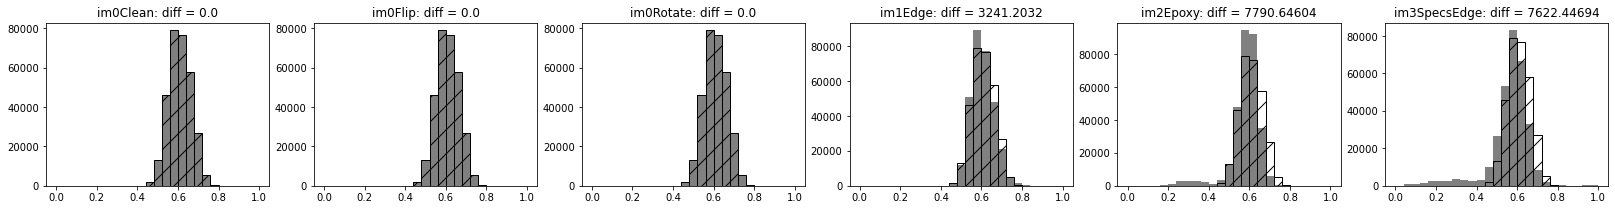

In [9]:
fig= plt.figure(figsize=(28,3))
axs = fig.subplots(1, 6)
for i, imN in enumerate(imArr):
    diff = (rgb2gray(imN)/255)
    base = (rgb2gray(imArr[0])/255)
    c,b,k = axs[i].hist((diff).flatten(), color = 'gray', range=(0., 1), bins=25)
    c0,b0,k0 = axs[i].hist((base).flatten(), hatch = '/', fill = False, range=(0., 1), bins=25)
    axs[i].set_title(imTitle[i] + ': diff = ' + str(np.round(np.sqrt(np.average((c-c0)**2)), 5)))

plt.show(); plt.close()

### Method 3: Look at non-zero bins < 0.4 and assign a score

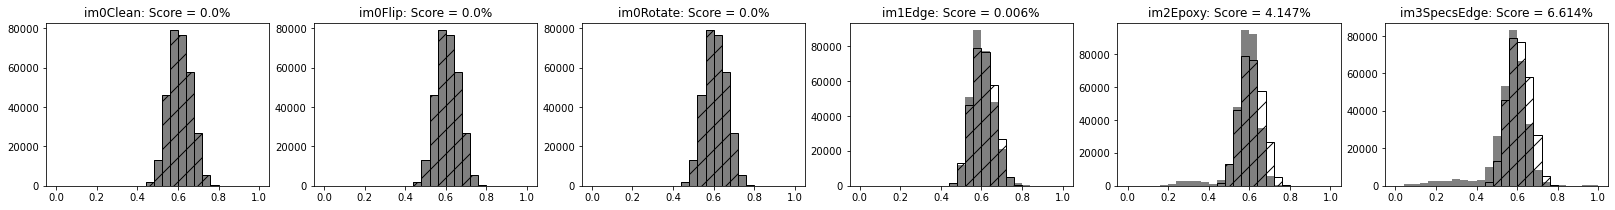

In [10]:
fig= plt.figure(figsize=(28,3))
axs = fig.subplots(1, 6)
for i, imN in enumerate(imArr):
    diff = (rgb2gray(imN)/255)
    base = (rgb2gray(imArr[0])/255)
    c,b,k = axs[i].hist((diff).flatten(), color = 'gray', range=(0., 1), bins=25)
    axs[i].hist((base).flatten(), hatch = '/', fill = False, range=(0., 1), bins=25)
    axs[i].set_title(imTitle[i] + ': Score = ' + 
                     str(np.round(  100*np.sum(c[np.where(b<0.4)[0]])/np.sum(c)   , 3))+'%')

plt.show(); plt.close()

### Method 4: Calculate pixel level chi-square (divided by number of pixels)
$$
\chi^2 = \sum_i \frac{(O_i - E_i)^2}{E_i}
$$
#### (Pixels are unlikely to be entirely black or white in greyscale, so there should be no divide-by-zero issues)

In [11]:
def chisqr(arr, arr0):
    return np.sum(np.square(arr-arr0)/arr0) /np.product(np.shape(arr0))

0.0
39.95555373110473
39.95555373110473
59.79103883652894
126.36087347215306
147.79238684606347


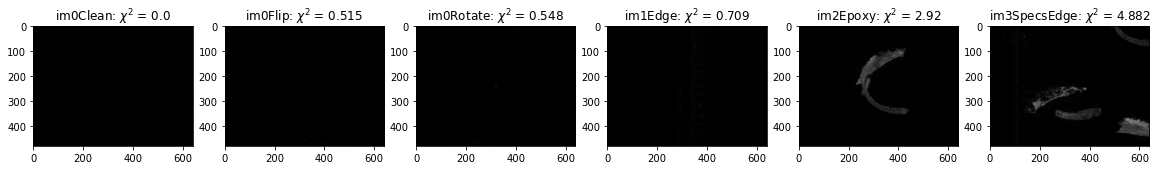

In [12]:
fig= plt.figure(figsize=(20,3))
axs = fig.subplots(1, 6)

for i in range(len(imArr)):
    tempIm = np.square( rgb2gray(imArr[i]) - rgb2gray(imArr[0])) /(rgb2gray(imArr[0]))
    print(np.max(tempIm))
    axs[i].imshow(tempIm, cmap='gray', vmin = 0, vmax = 255) 
    axs[i].set_title(imTitle[i]+': $\chi^2$ = '+  str(np.round(chisqr(rgb2gray(imArr[i]),rgb2gray(imArr[0])),3))   )

plt.show(); plt.close()

### Method 4: Using OpenCV K-means clustering
- Cluster images into three colours
- Ideally, impurities will be clustered into the darkest color.
- Image without impurities will have two lighter colours for the grains.
- Check for percentage of pixels that have darkesr colour.
- Need to optimize epsilon for speed.

##### Image needs to be in RGB, not grayscale, for best results. 

In [21]:
def getKmeanClus(img, K=3, epsilon=10):
    Z = np.float32(img.reshape((-1,3)))
    ## define criteria, number of clusters(K) and apply kmeans()
    ## maximum number of iteration; maximum value of epsilon 
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, epsilon)
    ret,label,center=cv.kmeans(Z, K=K, bestLabels=None, criteria=criteria, attempts=10, flags=cv.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = (center[label.flatten()]).reshape((img.shape))
    return rgb2gray(res)

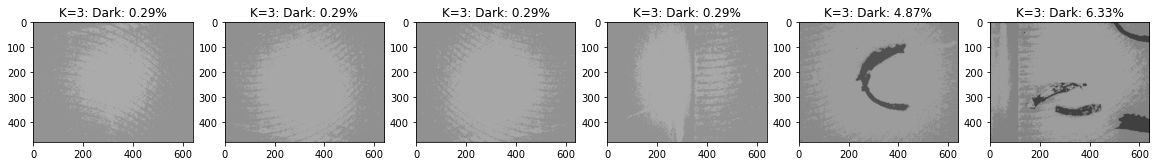

In [22]:
fig= plt.figure(figsize=(20,3))
axs = fig.subplots(1, 6)

for i in range(len(imArr)):
    clusIm = getKmeanClus(imArr[i])
    axs[i].imshow(clusIm, cmap='gray', vmin = 0, vmax = 255) 
    axs[i].set_title('K=3: '+imTitle[i])
    color, count = np.unique(clusIm.flatten(), return_counts=True)
    axs[i].set_title('K=3: Dark: ' + str(np.round( 100*count[0]/np.sum(count) ,2)  )+'%'  )

plt.show(); plt.close()